# Manual Feature Matching

In [1]:
import cv2 as cv2
import numpy as np  
import os
import matplotlib.pyplot as plt

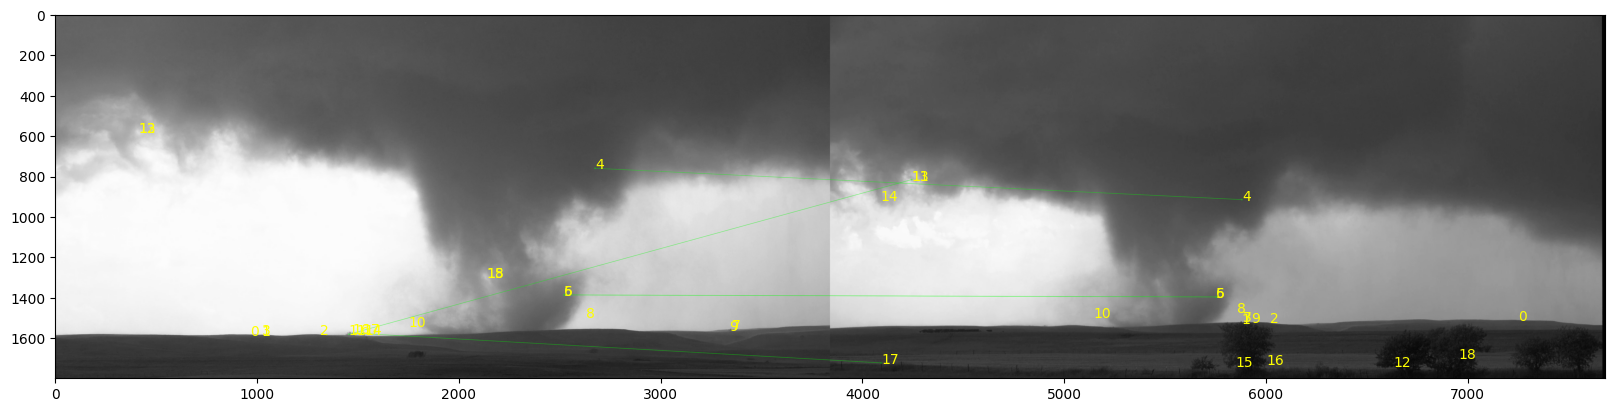

In [8]:
path = 'data/tornado_frame_groups/frames_0'
n1 = 'Schyma_4K_calibrated_81705.png'
n2 = 'Seimon_4K_calibrated_2024_corrected_81705.png'

# Read image grayscale
img1 = cv2.imread(os.path.join(path, n1), cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(os.path.join(path,  n2), cv2.IMREAD_GRAYSCALE)

# Read color versions
img1c = cv2.imread(os.path.join(path, n1), cv2.IMREAD_COLOR)
img2c = cv2.imread(os.path.join(path,  n2), cv2.IMREAD_COLOR)
img1c = cv2.cvtColor(img1c, cv2.COLOR_BGR2RGB)
img2c = cv2.cvtColor(img2c, cv2.COLOR_BGR2RGB)

# Crop watermark
img1 = img1[0:1800, 0:img1.shape[1]]
img2 = img2[0:1800, 0:img2.shape[1]]
img1c = img1c[0:1800, 0:img1c.shape[1]]
img2c = img2c[0:1800, 0:img2c.shape[1]]

# Show images
# fig, axs = plt.subplots(1, 2, figsize=(20, 10)) 
# axs[0].imshow(img1, cmap='gray')
# axs[1].imshow(img2, cmap='gray')

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

# BFMatcher with default params
bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(des1, des2)
matches = sorted(matches, key=lambda x: x.distance)

# Filter matches using ransac
pts1 = np.float32([kp1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, .99)
matchesMask = mask.ravel().tolist()

# Filter points by good matches
# good_matches = [m for m, mask in zip(matches, matchesMask) if mask]

# pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
# pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

# Draw only inliers
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None,
                   matchesMask=matchesMask,  # draw only inliers
                   flags=2)

img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, **draw_params)
# Annotate lines with keypoint index in array

# img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(20, 10))
plt.imshow(img3)  

for i, match in enumerate(matches):
    pt1 = kp1[match.queryIdx].pt
    pt2 = kp2[match.trainIdx].pt
    plt.annotate(f'{i}', (pt1[0], pt1[1]), color='yellow')
    plt.annotate(f'{i}', (pt2[0] + img1.shape[1], pt2[1]), color='yellow')
    

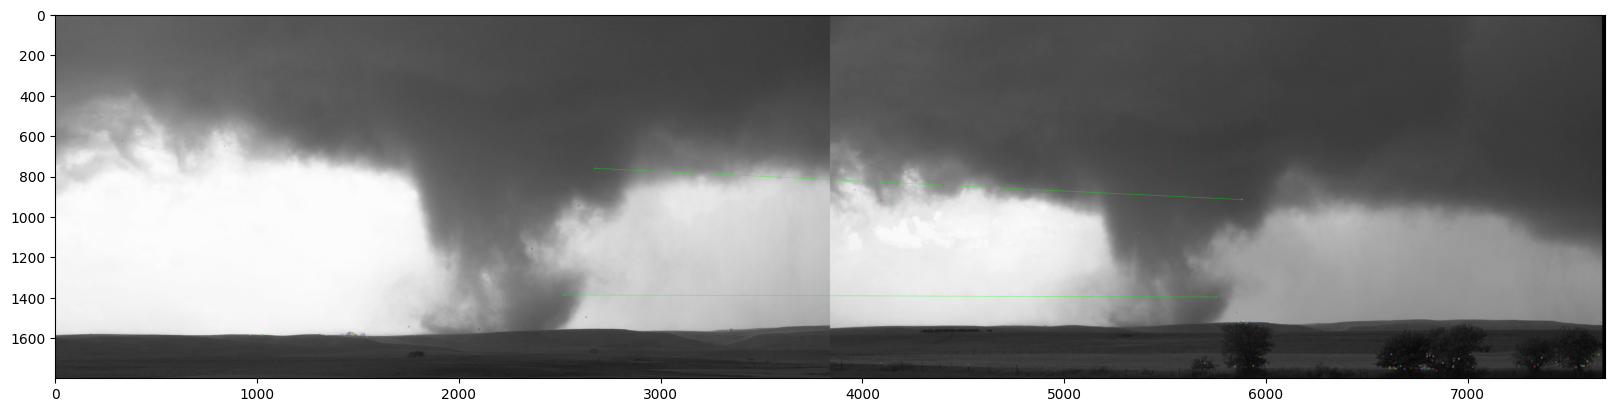

In [3]:
draw_params = dict(matchColor=(0, 255, 0),  # draw matches in green color
                   singlePointColor=None)
good_matches = cv2.drawMatches(img1,kp1,img2,kp2, [matches[4], matches[5]], None, **draw_params)
plt.figure(figsize=(20, 10))    
plt.imshow(good_matches)    

In [9]:
# pts1_good = np.float32([kp1[matches[4].queryIdx].pt, kp1[matches[5].queryIdx].pt]).reshape(-1, 1, 2)
# pts2_good = np.float32([kp2[matches[4].trainIdx].pt, kp2[matches[5].trainIdx].pt]).reshape(-1, 1, 2)
# pts1 = pts1_good
# pts2 = pts2_good

F, mask = cv2.findFundamentalMat(pts1,pts2, cv2.FM_LMEDS)

E, mask = cv2.findEssentialMat(pts1, pts2, focal=1.0, pp=(0, 0), method=cv2.RANSAC, prob=0.999, threshold=1.0)
ret, R, T, mask = cv2.recoverPose(E, pts1, pts2) # estimation of the relative camera pose

print("Homography Matrix (H):")
print(H)

print("Fundamental Matrix (F):")
print(F)

print("Essential Matrix (E):")
print(E)


Homography Matrix (H):
[[-7.72509631e-02 -1.23900047e+00  2.07559891e+03]
 [ 2.09851166e-02 -4.71505778e-01  7.18927507e+02]
 [-3.40049676e-05 -5.98076393e-04  1.00000000e+00]]
Fundamental Matrix (F):
[[-2.56686705e-08 -4.17481617e-06  6.65591466e-03]
 [ 3.97752241e-06  7.92182842e-07 -3.27052204e-03]
 [-6.07524923e-03  1.30095546e-03  1.00000000e+00]]
Essential Matrix (E):
[[-1.65363464e-05  3.67008577e-04 -5.56107685e-01]
 [-3.12958214e-04  1.83603678e-05  4.36742639e-01]
 [ 5.15056292e-01 -4.84475891e-01 -5.86645578e-05]]


In [10]:
f = max(img1.shape[0], img1.shape[1]) #estimate focal length
K = np.array([[f, 0, img1.shape[1]/2],
            [0, f, img1.shape[0]/2],
            [0, 0, 1]])

points1_norm = cv2.undistortPoints(pts1, K, None)
points2_norm = cv2.undistortPoints(pts2, K, None)

# Projection matrices for the two views
# First camera is at the origin: [I | 0]
P1 = np.hstack((np.eye(3), np.zeros((3, 1))))

# Second camera: [R | T]
P2 = np.hstack((R, T))

# Triangulate points
points4D_hom = cv2.triangulatePoints(P1, P2, points1_norm, points2_norm)

# Convert to 3D (inhomogeneous coordinates)
points3D = points4D_hom[:3] / points4D_hom[3]  # Divide by the homogeneous coordinate

print("Estimated 3D points:\n", points3D.T)

Estimated 3D points:
 [[ -0.2097392   -0.08209655   1.8868568 ]
 [ -0.85936      0.5518061    5.3643875 ]
 [ -0.59537315   0.724012     6.4808817 ]
 [ -0.85047555   0.5430735    5.3739476 ]
 [ -1.6381905   -0.17241836 -11.276134  ]
 [ -1.1704177   -1.6370089   -9.879508  ]
 [ -1.1704177   -1.6370089   -9.879508  ]
 [ -1.1857541   -1.0265721   -3.9545226 ]
 [ -1.3620334   -1.7466737   -9.105024  ]
 [ -1.2384818   -1.0594192   -4.143474  ]
 [  1.0217365   -2.7988055  -14.400888  ]
 [  0.49221787  -0.67542124  -3.233089  ]
 [ -0.45504263  -0.28272134   1.4632087 ]
 [ -6.008003    -0.8585654   14.37251   ]
 [  0.46264845  -0.7015926   -3.012181  ]
 [  0.33897156   1.8651524   13.875027  ]
 [ -0.4522715    0.8297357    6.1595616 ]
 [  1.1908056   -1.6496531   -5.8577156 ]
 [  0.4409689    0.21566436   4.0577374 ]]


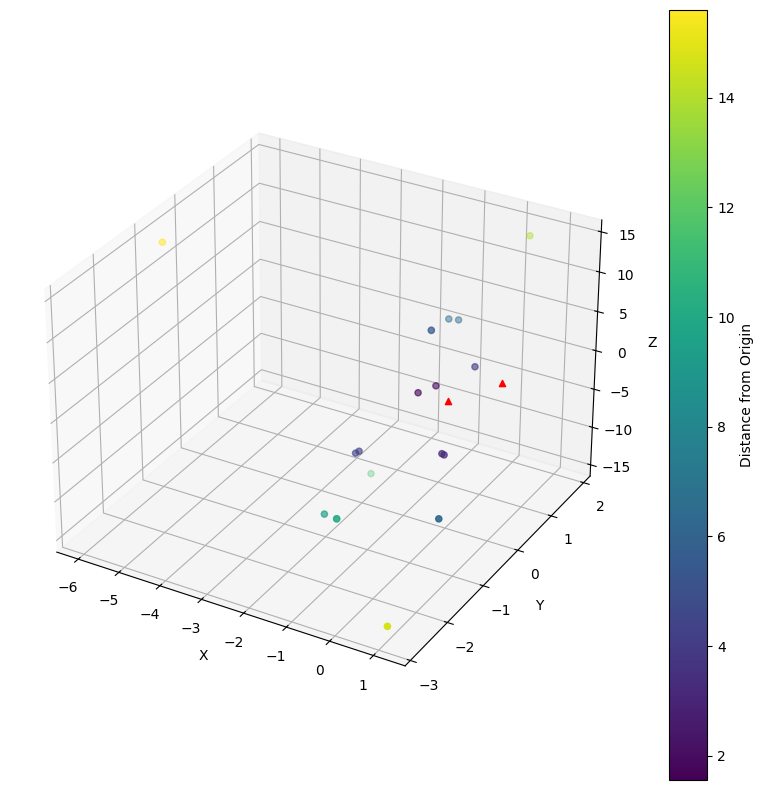

In [17]:
known_distance = 412.02 #distance in meters
camera_dist = np.linalg.norm(T, 2) 
point_dist = np.linalg.norm(points3D[0], 2)

distance = known_distance * (camera_dist / point_dist)
distance

distances = np.linalg.norm(points3D, axis=0)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D points with color based on distance from origin
sc = ax.scatter(points3D[0], points3D[1], points3D[2], c=distances, cmap='viridis', marker='o')
plt.colorbar(sc, label='Distance from Origin')
# Plot camera positions in red
ax.scatter(0, 0, 0, c='r', marker='^', label='Camera 1')  # Camera 1 at origin
ax.scatter(T[0], T[1], T[2], c='r', marker='^', label='Camera 2')  # Camera 2 at T
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

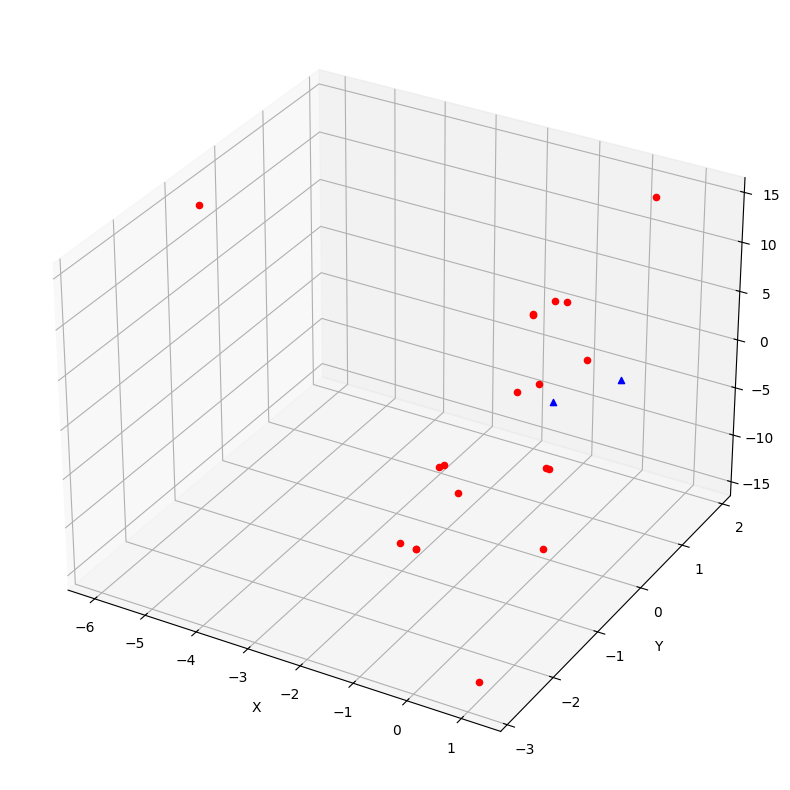

In [14]:

from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation

# Center the plot at the origin
points3D_centered = points3D - points3D.mean(axis=1, keepdims=True)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D points
for point in points3D.T:
    ax.scatter(point[0], point[1], point[2], c='r', marker='o')
# Plot camera positions
ax.scatter(0, 0, 0, c='b', marker='^')  # Camera 1 at origin
ax.scatter(T[0], T[1], T[2], c='b', marker='^')  # Camera 2 at T

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()
# Rotate the graph
def rotate(angle):
    ax.view_init(azim=angle)


ani = FuncAnimation(fig, rotate, frames=np.arange(0, 360, 1), interval=100)
plt.show()

In [ ]:
# Initialize disparity map
height, width = img1.shape
disparity_map = np.zeros((height, width), dtype=np.float32)

# Fill the disparity map
for match in np.array(matches)[matchesMask]:
    pt1 = kp1[match.queryIdx].pt  # Point in image1
    pt2 = kp2[match.trainIdx].pt  # Point in image2
    
    x1, y1 = int(pt1[0]), int(pt1[1])
    x2, y2 = int(pt2[0]), int(pt2[1])
    
    disparity_map[y1, x1] = x1 - x2  # Compute disparity

# Normalize for visualization
disparity_map = cv2.normalize(disparity_map, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_map = np.uint8(disparity_map)

# Colmap visualization

In [11]:
import pycolmap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
import cv2


In [27]:

# Path to the COLMAP reconstruction directory
colmap_dir = 'data/colmap_sets/colmap_field_cc_adv_gs/distorted/sparse/0'

# Load the reconstruction
reconstruction = pycolmap.Reconstruction(colmap_dir)

# Extract 3D points and camera positions
points3D = [point.xyz for point in reconstruction.points3D.values()]
cameras = [image.projection_center() for image in reconstruction.images.values()]


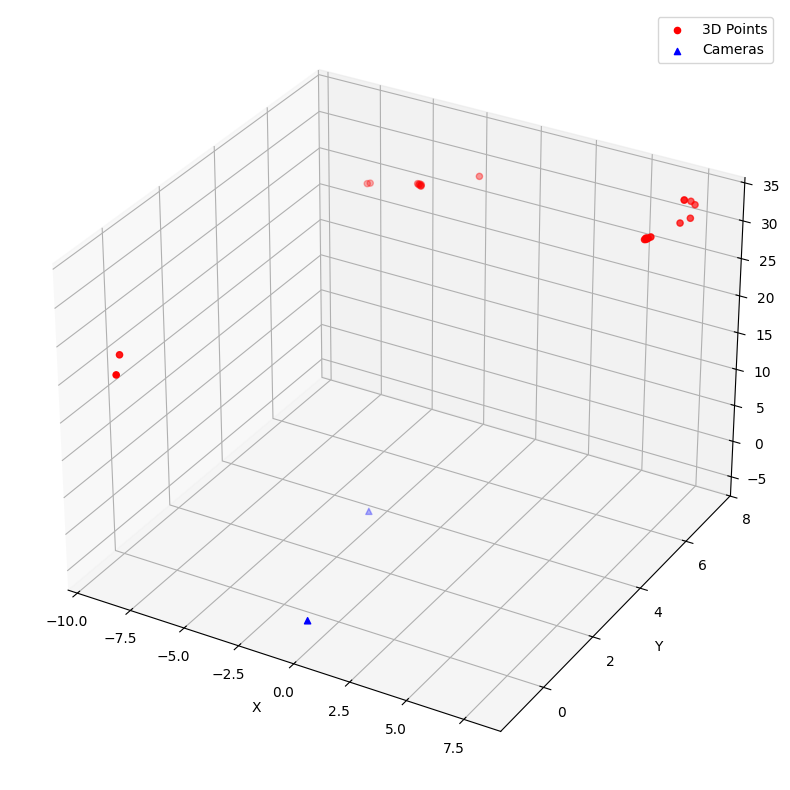

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot 3D points
points3D_array = np.array(points3D)
ax.scatter(points3D_array[:, 0], points3D_array[:, 1], points3D_array[:, 2], c='r', marker='o', label='3D Points')

# Plot camera positions
cameras_array = np.array(cameras)
ax.scatter(cameras_array[:, 0], cameras_array[:, 1], cameras_array[:, 2], c='b', marker='^', label='Cameras')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()

plt.show()

error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cv::cvtColor'


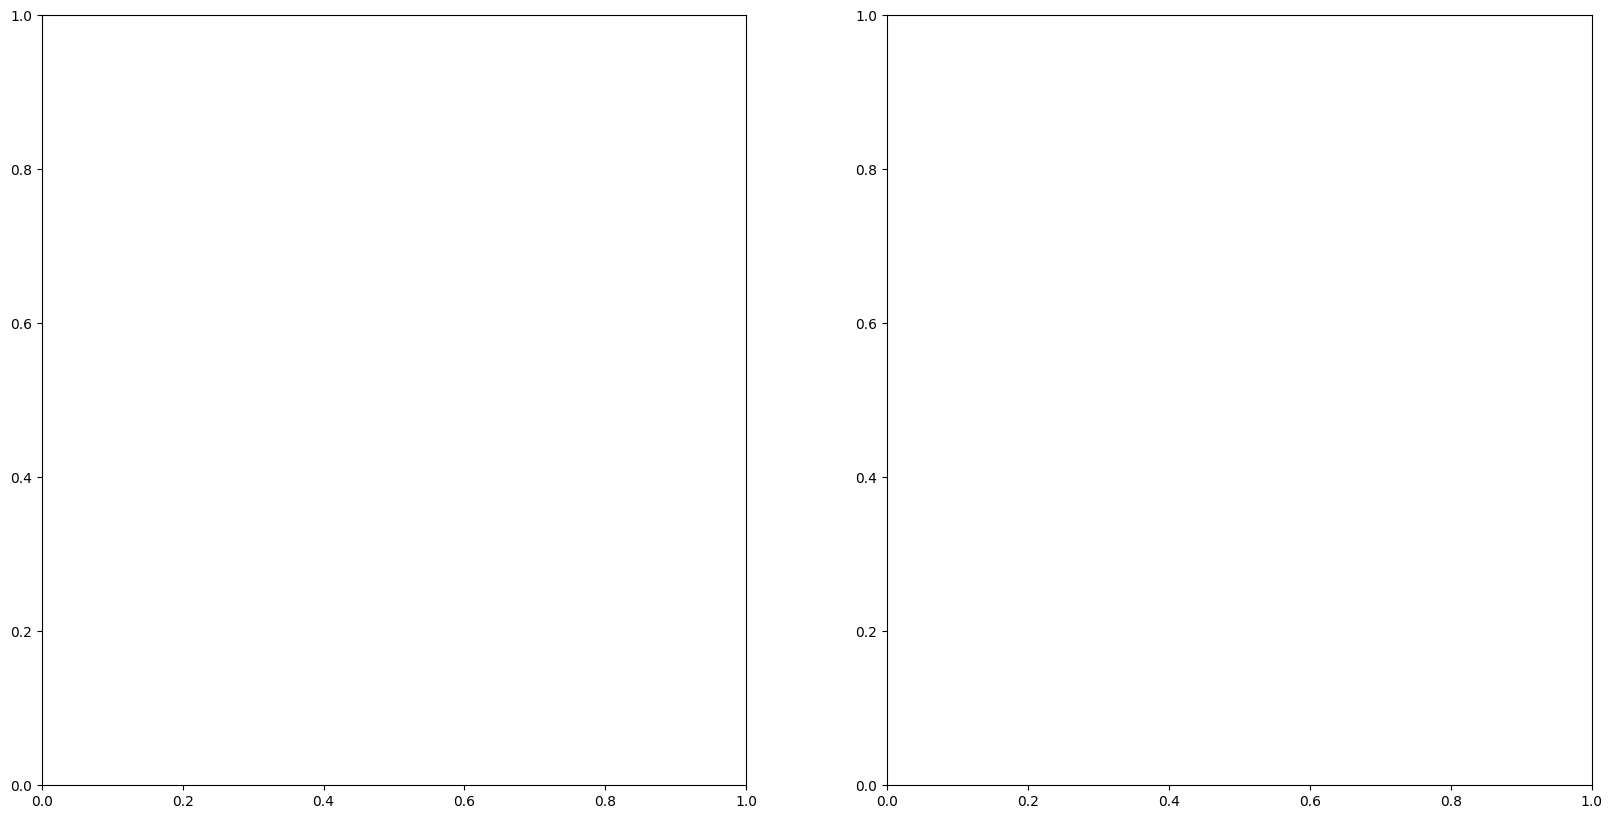

In [29]:
# Extract image names and their corresponding keypoints

image_names = [image.name for image in reconstruction.images.values()]
keypoints = [image.points2D for image in reconstruction.images.values()]

# Plot keypoints on images
fig, axs = plt.subplots(1, len(image_names), figsize=(20, 10))

for ax, image_name, kps in zip(axs, image_names, keypoints):
    a = kps
    img_path = os.path.join('data/colmap_sets/colmap_field_cc_adv_gs/input', image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    pts =([kp.xy for kp in kps])
    y = np.array([kp[1] for kp in kps])
    ax.imshow(img)
    ax.scatter(kps[:], kps[:, 1], c='r', s=5)
    ax.set_title(image_name)
    ax.axis('off')

plt.show()

In [36]:
plt.imshow(cv2.imread(reference))

error: OpenCV(4.10.0) :-1: error: (-5:Bad argument) in function 'imread'
> Overload resolution failed:
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object
>  - Expected 'filename' to be a str or path-like object


In [24]:
os.listdir(path)

['schyma_0.png', 'schyma_rx_0.png', 'talbot_0.png']

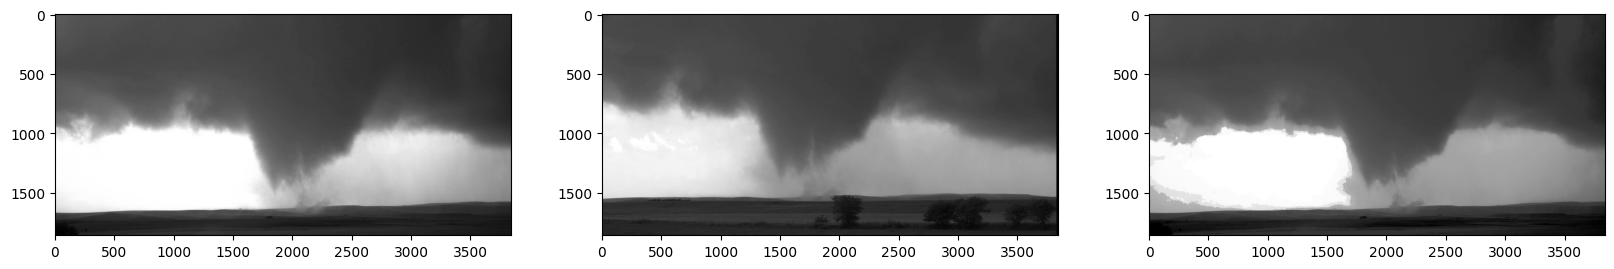

In [16]:
# Plot intensities of color matched images
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
i1 = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
i2 = cv2.cvtColor(reference, cv2.COLOR_BGR2GRAY)
i3 = cv2.cvtColor(matched, cv2.COLOR_BGR2GRAY)

axs[0].imshow(i1, cmap='gray')  
axs[1].imshow(i2, cmap='gray')
axs[2].imshow(i3, cmap='gray')


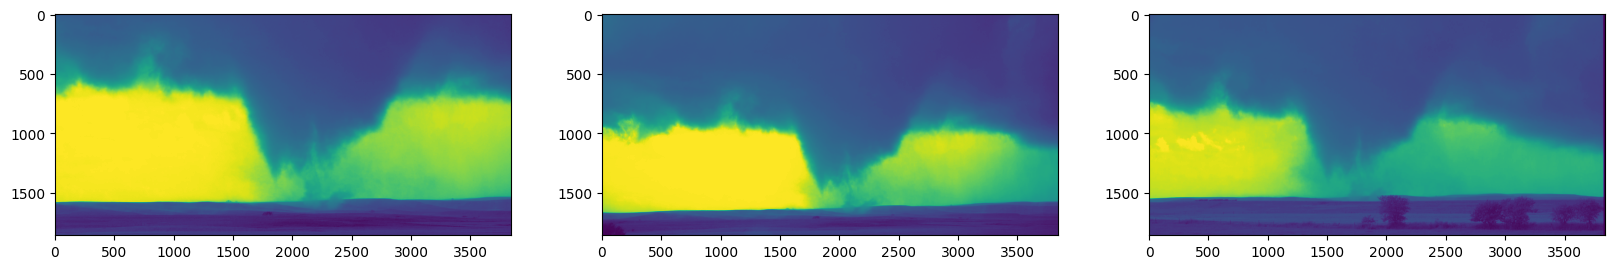

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
for image, ax in zip(os.listdir(path), axs):
    img = cv2.imread(os.path.join(path, image), cv2.IMREAD_GRAYSCALE)
    ax.imshow(img)


In [23]:
path = 'data/colmap_sets/colmap_field_cc_adv/input/'

for image in os.listdir(path):
    img = cv2.imread(os.path.join(path, image))
    img = img[0:-300, :]
    cv2.imwrite(os.path.join(path, image), img)